# Alzheimer's Disease Capstone Project
## Machine Learning and Predictive Modeling

The two primary questions that this analysis is trying to answer are:
1. Which biomarkers are correlated with a change in diagnosis to Alzheimer's Disease?
2. Which biomarkers might be able to predict a final diagnosis of Alzhiemer's Disease at an initial visit?

In [1]:
# load packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve

# load custom modules
from adnidatawrangling import wrangle_adni
import eda, ml

# set default plotting
plt.style.use('ggplot')

## 1. Which Biomarkers Are Correlated with a Progression Towards Alzheimer's Disease?
- Steps
    - Prepare data for analysis
        - Import/wrangle/clean
        - Extract the last exam and basline data
        - Calculate the change for each variables (deltas)
        - Extract the features and standardize the data
        - Separate the target and feature data

In [2]:
# import data, clean, and extract data
adni_comp, clin_data, scan_data = wrangle_adni()

# extract final exam data: only the last exam for each patient
final_exam = eda.get_final_exam(adni_comp)

# calculate the change in variables over the course of the study
eda.calc_deltas(final_exam)

# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

In [3]:
# examine the structure of the data
print(feature_names.shape)
print(Xd.shape, yd.shape)

(11,)
(1134, 11) (1134,)


In [4]:
# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

#### First Model k-Nearest Neighbors Classification
- The first model will try k-NN to predict the groups
- First, the best k will be chosen
    - Graphic approach
    - GridSearchCV approach

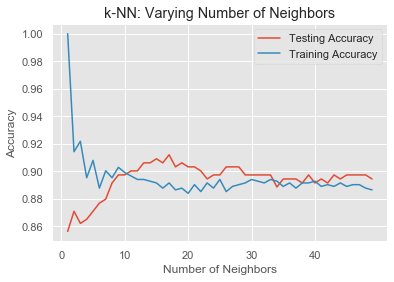

In [5]:
# plot the training and test accuracy with varying k values
ml.plot_best_k(Xd_train, Xd_test, yd_train, yd_test, kmax=50)

- Using this approach, the testing accuracy was highest at k=17. The test accuracy continues decrease a little after this, however, and it looks like both lines level out around the mid 30s. There could therefore be a few choices of k. Crossvalidation will be used to provide another measure of the best k. 

In [6]:
# find best k using GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)

knn_cv.fit(Xd_train, yd_train)

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 39} 0.8890290037831021


- GridSearchCV returned 39 as the best k. Because the first method was a little ambiguous but still gave one option in the 30s, we will use 39 for k.

#### k-Nearest Neighbors Model in Action

In [7]:
# create the model
knn = KNeighborsClassifier(n_neighbors=39)

# fit the model
knn.fit(Xd_train, yd_train)

# generate predictions
y_pred = knn.predict(Xd_test)

In [8]:
# print the accuracy
print('Training Accuracy: {}'.format(knn.score(Xd_train, yd_train)))
print('Testing Accuracy: {}'.format(knn.score(Xd_test, yd_test)))

Training Accuracy: 0.8915510718789408
Testing Accuracy: 0.8973607038123167


In [9]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[280   7]
 [ 28  26]]
True Negatives: 280
False Positives: 7
False Negatives: 28
True Positives: 26


- The confusion matrix shows that this model is very good at predicting the true negatives. However, there were more false negatives than true positives, meaning the model does not have much power to detect Alzheimer's disease.
- Analyzing the precision and recall will provide more details.

In [10]:
k = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       287
           1       0.79      0.48      0.60        54

    accuracy                           0.90       341
   macro avg       0.85      0.73      0.77       341
weighted avg       0.89      0.90      0.89       341



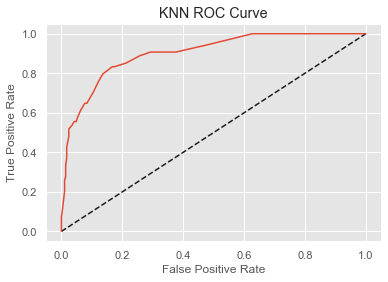

In [11]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = knn.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='KNN')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('KNN ROC Curve')

In [12]:
# compute the AUC
print(roc_auc_score(yd_test, y_pred_prob))

0.9012453219770293


- The ROC curve and auc score appear to be very good, however, this is an artifact of the imbalanced data, with the model doing very well with true negatives. The precision/recall curve illustrates this below.

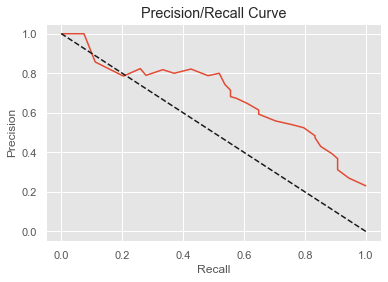

In [13]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision/recall curve illustrates that recall is not very good at high levels of precision. There is not much predictive value in the model when the precision or sensitivity is high. 

- While it is possible that the model could be improved by oversampling on the Alzheimer's group, different models will be tried that can account for the imbalanced data.

#### SVM Model

In [14]:
# extract and scale the deltas data for ML analysis using -1 and 1 as the classes for SVM
feature_names, Xd, yd = ml.get_delta_scaled(final_exam, neg_one=True)

# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

num_features = len(feature_names)

In [15]:
# setup parameters to hyptertune
param_grid = {'C': [0.5, 0.75, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*Xd_train.var())), (1/num_features)]}

svm = SVC(class_weight='balanced', probability=True)

svm_cv = GridSearchCV(svm, param_grid, cv=5)

svm_cv.fit(Xd_train, yd_train)

C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 0.75, 'gamma': 0.09071642694696025} 0.8373266078184111


In [16]:
# create the model
svm = SVC(C=C, gamma=gamma, class_weight='balanced',
         probability=True)

# fit the model
svm.fit(Xd_train, yd_train)

# generate predictions
y_pred = svm.predict(Xd_test)

In [17]:
# print the accuracy
print('The training accuracy was: {}'.format(svm.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(svm.score(Xd_test, yd_test)))

The training accuracy was: 0.8701134930643127
The test accuracy was: 0.841642228739003


In [18]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[244  43]
 [ 11  43]]
True Negatives: 244
False Positives: 43
False Negatives: 11
True Positives: 43


- The SVM model did a better job with the true positives vs. false negatives than the knn model when using class weighting to account for the imbalanced data.
- The model did produce 43 false positives, but 50% of the patients the model flagged as positive did actually develop AD during the study.
- Of the patients that didn't develop AD, only 15% were incorrectly classified as false positive.
- The model did fail to predict 11 patients that did progress to AD, and it had a detection rate of around 80%

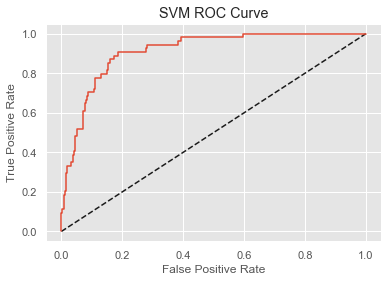

In [19]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = svm.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='SVM')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM ROC Curve')

In [20]:
s = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.85      0.90       287
           1       0.50      0.80      0.61        54

    accuracy                           0.84       341
   macro avg       0.73      0.82      0.76       341
weighted avg       0.88      0.84      0.86       341



- The recall was much improved for the Alzheimer's class, but at the expense of precision. For this instance, this would be more desirable and a few false positives may be worth higher detection power when predicting AD.

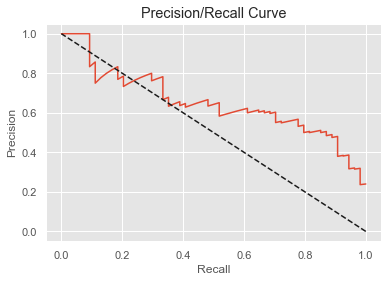

In [21]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve once again shows that the model suffers when recall is < 0.4. The model is better at predicting negative results than positive results. For this application, a model that can do well with the Alzheimer's or positive class is desired.

#### Random Forest Classifier

In [22]:
# extract and scale the deltas data for ML analysis using 0 and 1 as the classes for Random Forest
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

In [23]:
# tune hyperparameters n_estimators and max_features
trees = [131, 141, 151, 161, 171]

max_f = [1, 10, 'log2', 'sqrt']

param_grid = {'n_estimators': trees, 'max_features': max_f}

r_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

r_forest_cv = GridSearchCV(r_forest, param_grid, cv=5)

r_forest_cv.fit(Xd_train, yd_train)

n_est = r_forest_cv.best_params_['n_estimators']
n_feat = r_forest_cv.best_params_['max_features']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(r_forest_cv.best_params_, r_forest_cv.best_score_)

{'max_features': 1, 'n_estimators': 151} 0.8965952080706179


In [24]:
# build the model
rfc = RandomForestClassifier(n_estimators=n_est, max_features=n_feat, 
                             class_weight='balanced', random_state=42)

# fit the model
rfc.fit(Xd_train, yd_train)

# generate predictions
y_pred = rfc.predict(Xd_test)

In [25]:
# print the accuracy
print('The training accuracy was: {}'.format(rfc.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(rfc.score(Xd_test, yd_test)))

The training accuracy was: 1.0
The test accuracy was: 0.8856304985337243


In [26]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[275  12]
 [ 27  27]]
True Negatives: 275
False Positives: 12
False Negatives: 27
True Positives: 27


- Cross validation picked 1 for the max tree length, using only stumps for each tree.
- The random forest model did very well with the negative class, but once again failed to perform for the positive class (Alzheimer's disease). 
- Patients that didn't progress to Alzheimer's were predicted pretty accurately, but only 50% of the patients that progressed to Alzheimer's were identified by the model.
- If a doctor is taking a very cautious approach to warning patients, then this could be a good model. Most of the patients that would not be warned about being at risk would not develop AD (248/302, about 82%).
- This model did have a better positive detection rate vs. SVM, with nearly 70% of patients flagged as postive actually developing AD.

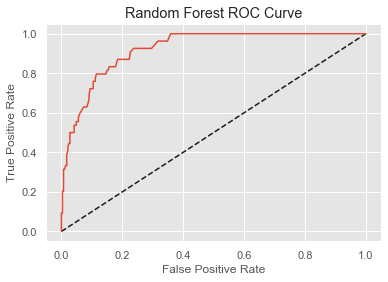

In [27]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = rfc.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='RFC')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Random Forest ROC Curve')

In [28]:
r = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       287
           1       0.69      0.50      0.58        54

    accuracy                           0.89       341
   macro avg       0.80      0.73      0.76       341
weighted avg       0.88      0.89      0.88       341



- Both the precision and recall were lower for the positive (AD) class.

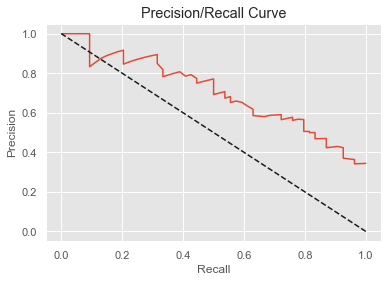

In [29]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

#### AdaBoost for Boosting

In [30]:
# tune hyperparameter number of estimators
est = [41, 51, 61, 71, 81]

param_grid = {'n_estimators': est}

boost = AdaBoostClassifier(random_state=42)

boost_cv = GridSearchCV(boost, param_grid, cv=5)

boost_cv.fit(Xd_train, yd_train)

n_est = boost_cv.best_params_['n_estimators']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 51} 0.8751576292559899


In [31]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xd_train, yd_train)
y_pred = model.predict(Xd_test)
print('Training accuracy: {}'.format(model.score(Xd_train, yd_train)))
print('Testing accuracy: {}'.format(model.score(Xd_test, yd_test)))

Training accuracy: 0.9344262295081968
Testing accuracy: 0.8826979472140762


In [32]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[265  22]
 [ 18  36]]
True Negatives: 265
False Positives: 22
False Negatives: 18
True Positives: 36


- Boosting improved on the random forest model for prediction power, with 2/3 of the 54 patients with AD being correctly identified.
- The model still failed to detect progression to AD in 18 patients, however.
- This model might be preferred by cautious doctors that would rather have false negatives than false positives.

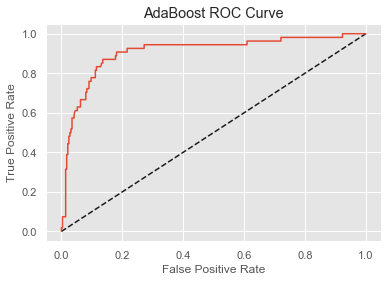

In [33]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Boost')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('AdaBoost ROC Curve')

In [34]:
b = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       287
           1       0.62      0.67      0.64        54

    accuracy                           0.88       341
   macro avg       0.78      0.80      0.79       341
weighted avg       0.89      0.88      0.88       341



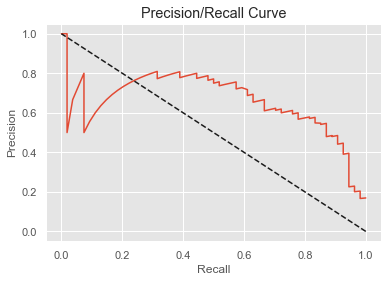

In [35]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve again shows the tradeoff in prediction power with high precision.
- Overall, the model's performance is not satisfactory for prediction a progression to AD.

- Simple feature selection using feature_importances_

In [36]:
# get the feature importances in a dataframe
feat = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
feat.sort_values('importance', ascending=False)

,feature,importance
5,Hippocampus_delta,0.215686
6,Ventricles_delta,0.156863
0,CDRSB_delta,0.137255
7,WholeBrain_delta,0.117647
2,ADAS13_delta,0.098039
9,MidTemp_delta,0.078431
1,ADAS11_delta,0.058824
8,Entorhinal_delta,0.058824
3,MMSE_delta,0.039216
4,RAVLT_delta,0.039216


In [37]:
# omit zero/low importance features and run the model again
mask = (feature_names != 'MMSE_delta') & (feature_names != 'RAVLT_delta') & (feature_names != 'PTGENDER_Male')
Xtrain_reduced = Xd_train[:,mask]
Xtest_reduced = Xd_test[:,mask]

est = [1, 11, 21, 31, 41]
param_grid = {'n_estimators': est}
boost = AdaBoostClassifier(random_state=42)
boost_cv = GridSearchCV(boost, param_grid, cv=5)
boost_cv.fit(Xtrain_reduced, yd_train)
n_est = boost_cv.best_params_['n_estimators']
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 21} 0.8827238335435057


In [38]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xtrain_reduced, yd_train)
y_pred = model.predict(Xtest_reduced)
print('Training accuracy: {}'.format(model.score(Xtrain_reduced, yd_train)))
print('Testing accuracy: {}'.format(model.score(Xtest_reduced, yd_test)))

Training accuracy: 0.914249684741488
Testing accuracy: 0.8768328445747801


In [39]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[262  25]
 [ 17  37]]
True Negatives: 262
False Positives: 25
False Negatives: 17
True Positives: 37


- The model is very similar to the full feature model, trading one additional true positive for three false negatives. As the goal of this analysis is to predict patients that may be at a higher risk of Alzheimer's, I would consider this an improvement on the original model.

#### Logistic Regression

In [40]:
# build the model
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg.fit(Xd_train, yd_train)

# generate predictions
y_pred = logreg.predict(Xd_test)

In [41]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(logreg.score(Xd_test, yd_test)))

The training accuracy was: 0.8562421185372006
The test accuracy was: 0.8533724340175953


In [42]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[244  43]
 [  7  47]]
True Negatives: 244
False Positives: 43
False Negatives: 7
True Positives: 47


- The logistic model performed better at identifying patients that progressed to AD at the expense of adding more false positives.
- This model would be preferred by physicians that would rather catch every patient at a high risk of AD while not as concerned with false positives.
- While there were 43 false positives, 244/287 (85%) of the patients that didn't progress to AD were correctly identified by this model.
- The detection rate was similar at 47/54 or about 87%.
- This the best model so far for predicting progression to AD, improving on the SVM model that was leading to this point.

In [43]:
l = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       287
           1       0.52      0.87      0.65        54

    accuracy                           0.85       341
   macro avg       0.75      0.86      0.78       341
weighted avg       0.90      0.85      0.87       341



- The recall (detection rate) was much higher for the positive class, and the negative detection rate of 85% was also good. Precision was not great for the Alzheimer's class, with only about half of those identified as at risk for AD were diagnosed with the disease by the end of the study.
- Still, of these patients, some may have been diagnosed after the study, and this may be an acceptable rate when the recall rates are considered.

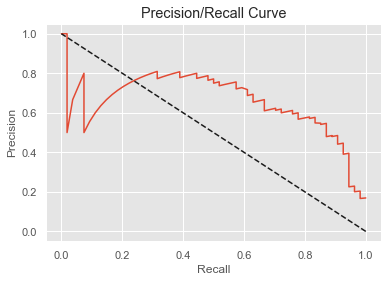

In [44]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- Once again, the precision was low, but this is partly due to the imbalanced data. This model has performed the best so far. The ROC-AUC metrics support this.

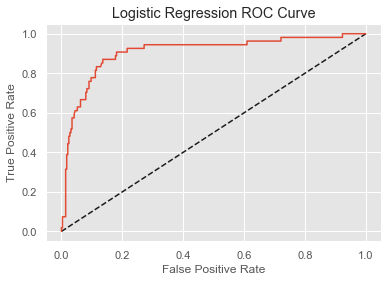

In [45]:
# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Logistic Regression')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Logistic Regression ROC Curve')

In [46]:
# compute the AUC
print(roc_auc_score(yd_test, y_pred_prob))

0.9068912117692605


- Simple feature selection using the coefficients from the logistic model

In [47]:
# print the coefficients for understanding feature importance
feat = pd.DataFrame({'feature': feature_names, 'coefficients': logreg.coef_[0]})
feat.loc[:,'abs_c'] = abs(feat.coefficients)
feat.sort_values('abs_c', ascending=False)

,feature,coefficients,abs_c
0,CDRSB_delta,1.538494,1.538494
2,ADAS13_delta,0.745273,0.745273
1,ADAS11_delta,-0.490206,0.490206
3,MMSE_delta,-0.476861,0.476861
5,Hippocampus_delta,-0.411781,0.411781
6,Ventricles_delta,0.349417,0.349417
7,WholeBrain_delta,0.307426,0.307426
10,PTGENDER_Male,0.213226,0.213226
8,Entorhinal_delta,-0.185719,0.185719
9,MidTemp_delta,-0.037181,0.037181


In [48]:
# running the model without RAVLT_delta and MidTemp_delta: indexes 4 and 9
mask = (feat.feature != 'MidTemp_delta') & (feat.feature != 'RAVLT_delta')
Xtrain_reduced = Xd_train[:,mask]
Xtest_reduced = Xd_test[:,mask]

In [49]:
# build the model
logreg2 = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg2.fit(Xtrain_reduced, yd_train)

# generate predictions
y_pred = logreg2.predict(Xtest_reduced)

In [50]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg2.score(Xtrain_reduced, yd_train)))
print('The test accuracy was: {}'.format(logreg2.score(Xtest_reduced, yd_test)))

The training accuracy was: 0.8587641866330391
The test accuracy was: 0.8563049853372434


In [51]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[245  42]
 [  7  47]]
True Negatives: 245
False Positives: 42
False Negatives: 7
True Positives: 47


- Model performance was very similar, with one fewer false positive. The detection rate did not change, which is the primary metric that I am trying to improve.

#### Naive Bayes

In [52]:
# get rid of negative values in the feature data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(Xd_train)

# instantize the model
model = MultinomialNB()

# fit the model
model.fit(X_scaled, yd_train)

# generate predictions
y_pred = model.predict(Xd_test)

In [53]:
# print the accuracy
print('The training accuracy was: {}'.format(model.score(X_scaled, yd_train)))
print('The test accuracy was: {}'.format(model.score(Xd_test, yd_test)))

The training accuracy was: 0.8411097099621689
The test accuracy was: 0.8475073313782991


In [54]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[254  33]
 [ 19  35]]
True Negatives: 254
False Positives: 33
False Negatives: 19
True Positives: 35


- Naive Bayes took a balanced approach to this problem. The detection rate was better than some models with about 65% detection rate. 
- Like some of the other models, this model performed better on the negative class, with 93% of the negative classifications being correct.
- This model underperformed with respect to detecting AD, but could be useful if a doctor is wanting to avoid false positives.

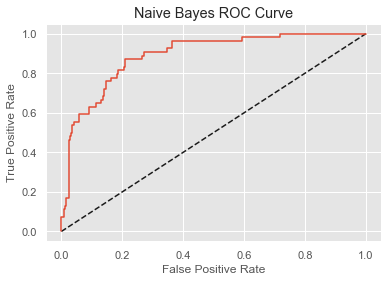

In [55]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='NB')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Naive Bayes ROC Curve')

In [56]:
n = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       287
           1       0.51      0.65      0.57        54

    accuracy                           0.85       341
   macro avg       0.72      0.77      0.74       341
weighted avg       0.86      0.85      0.85       341



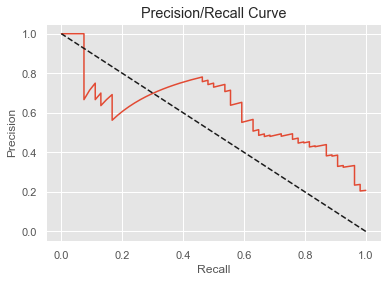

In [57]:
# plot the precision/recall curve
y_pred_prob = model.predict_proba(Xd_test)[:,1]
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall plot illustrates the lack of prediction power when precision is high.

## 1. Question One Summary: Detecting a Progression to Alzheimer's by Analyzing Changes in Biomarkers
- The Logistic Regression model performed the best at detecting AD, followed by AdaBoost and SVM.
    - These were the best models for detection power, producing the least amount of false negatives.
    - Each of these three models had higher false positive rates than the other models, but my opinion is that a certain number of false positives is acceptable for trying to start early brain training excercises to prevent AD.
    - The overall false positive rates were still low, considering the total number of patients that did not develop AD, and model performance was good for the Non AD class for all models (red bars).
- Several models performed well on the negative class, at the expense of losing detection power for Alzheimer's Disease.

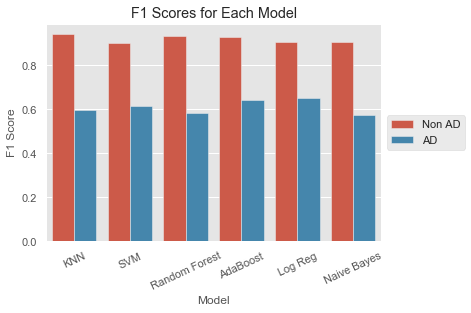

In [58]:
# plot the f1-scores for each model
ml.plot_f1_scores(k, s, r, b, l, n)

## 2. Can Baseline Biomarkers Be Used to Predict Alzheimer's?

In [59]:
# extract just the baseline data features
feature_names, Xb, yb = ml.get_bl_data(final_exam)

In [60]:
# examine the shape of the arrays
print(Xb.shape, yb.shape)

(1170, 11) (1170,)


In [61]:
# split the data into training and test datasets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, 
                                                    random_state=21, stratify=yb)

#### k-NN model

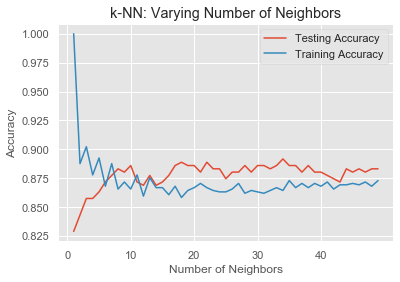

In [62]:
# plot the training and test accuracy with varying k values
ml.plot_best_k(Xb_train, Xb_test, yb_train, yb_test, kmax=50)

- A graphical approach suggests that 18 or higher would be a good choice. Seeing as this is one test run of the data, cross validation may provide a slightly different result.

In [63]:
# find best k using GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)

knn_cv.fit(Xb_train, yb_train)

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 25} 0.8644688644688645


- The best k when chosen over five cross validation folds is 25 neighbors, and that is what will be used for the model.

In [64]:
# create the model
knn = KNeighborsClassifier(n_neighbors=25)

# fit the model
knn.fit(Xb_train, yb_train)

# generate predictions
y_pred = knn.predict(Xb_test)

In [65]:
# print the accuracy
print('Training Accuracy: {}'.format(knn.score(Xb_train, yb_train)))
print('Testing Accuracy: {}'.format(knn.score(Xb_test, yb_test)))

Training Accuracy: 0.8632478632478633
Testing Accuracy: 0.8746438746438746


In [66]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[227  18]
 [ 26  80]]
True Negatives: 227
False Positives: 18
False Negatives: 26
True Positives: 80


- Right away, this model shows some predictive value for Alzheimer's disease using only baseline data. There were 26 false negatives, but this only represents about 25% of those with AD, meaning this model had a 75% detection rate.
- To achieve this, there were some false positives, but only about 7% of patients that didn't develop AD would have been flagged as at risk.
- This model shows value immediately with a very low false positive rate and a potentially acceptable detection rate. Doctors that wanted to take a conservative approach to warning patients would do well to choose this model.

In [67]:
k = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       245
           1       0.82      0.75      0.78       106

    accuracy                           0.87       351
   macro avg       0.86      0.84      0.85       351
weighted avg       0.87      0.87      0.87       351



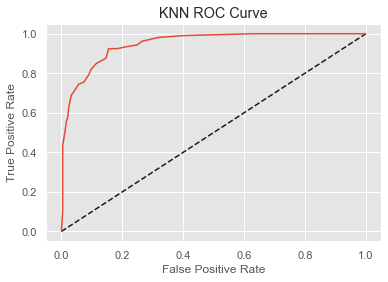

In [68]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = knn.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='KNN')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('KNN ROC Curve')

In [69]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9485560261840584


- The AUC score was very high, nearly 95%. This measure is slightly skewed by the performance on the non-AD patients, but the data are less imbalanced than for the first question, so this is further evidence that this is a decent model.

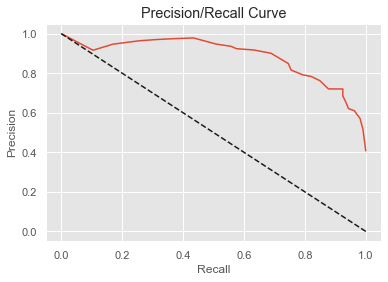

In [70]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve already looks better than any of the curves for the first question examining changes in biomarkers. 
- The first attempt at building a model to predict AD from baseline biomarkers was successful, but additional algorithms will be tried in an attempt to improve predictions.

#### SVM

In [71]:
# extract and scale the baseline data for ML analysis using -1 and 1 as the classes for SVM
feature_names, Xb, yb = ml.get_bl_data(final_exam, neg_one=True)

# split the data into test and train sets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, 
                                                    random_state=21, stratify=yb)

num_features = len(feature_names)

In [72]:
# setup parameters to hyptertune
param_grid = {'C': [0.5, 0.75, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*Xd_train.var())), (1/num_features)]}

svm = SVC(class_weight='balanced', probability=True)

svm_cv = GridSearchCV(svm, param_grid, cv=5)

svm_cv.fit(Xb_train, yb_train)

C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 1.25, 'gamma': 0.09071642694696025} 0.8644688644688645


In [73]:
# create the model
svm = SVC(C=C, gamma=gamma, class_weight='balanced',
         probability=True)

# fit the model
svm.fit(Xb_train, yb_train)

# generate predictions
y_pred = svm.predict(Xb_test)

In [74]:
# print the accuracy
print('The training accuracy was: {}'.format(svm.score(Xb_train, yb_train)))
print('The test accuracy was: {}'.format(svm.score(Xb_test, yb_test)))

The training accuracy was: 0.8852258852258852
The test accuracy was: 0.8490028490028491


In [75]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[202  43]
 [ 10  96]]
True Negatives: 202
False Positives: 43
False Negatives: 10
True Positives: 96


- Like with the first question, the SVM model improves on k-NN for detection power. This model had a 91% detection rate for Alzheimer's disease just using data from patients' first visit!
- This model improvement did come at the expense of additional false positives, however, the false positive rate was just 18%. 
- This model would be a good choice for a doctor that wanted to catch most of the patients that would progrss to AD eventually, if they were ok with informing a few patients that they were higher risk, when they may not end up progressing to AD.

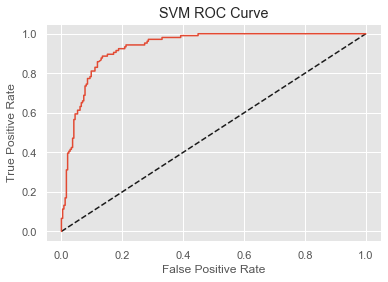

In [76]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = svm.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='SVM')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM ROC Curve')

In [77]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9322680015402387


In [78]:
s = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      0.82      0.88       245
           1       0.69      0.91      0.78       106

    accuracy                           0.85       351
   macro avg       0.82      0.87      0.83       351
weighted avg       0.87      0.85      0.85       351



- As expected, the AUC score was higher than the F1 scores for either group, most likely attributable to imbalanced data, however, this model was still an improvement over k-NN, with a slightly lower AUC score, but a higher recall for the AD class.

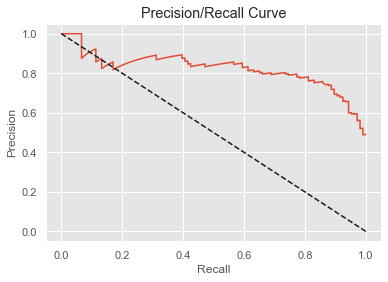

In [79]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision/recall curve clearly shows the tradeoff between high precision and recall. However, in this instance, higher recall is the goal with predicting AD the real value in this model.

#### Random Forest

In [80]:
# extract and scale the baseline data for ML analysis using 0 and 1 as the classes for Random Forest
feature_names, Xb, yb = ml.get_bl_data(final_exam)

# split the data into test and train sets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, 
                                                    random_state=21, stratify=yb)

In [81]:
# tune hyperparameters n_estimators and max_features
trees = [131, 141, 151, 161, 171]

max_f = [1, 10, 'log2', 'sqrt']

param_grid = {'n_estimators': trees, 'max_features': max_f}

r_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

r_forest_cv = GridSearchCV(r_forest, param_grid, cv=5)

r_forest_cv.fit(Xb_train, yb_train)

n_est = r_forest_cv.best_params_['n_estimators']
n_feat = r_forest_cv.best_params_['max_features']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(r_forest_cv.best_params_, r_forest_cv.best_score_)

{'max_features': 10, 'n_estimators': 161} 0.8693528693528694


In [82]:
# build the model
rfc = RandomForestClassifier(n_estimators=n_est, max_features=n_feat, 
                             class_weight='balanced', random_state=42)

# fit the model
rfc.fit(Xb_train, yb_train)

# generate predictions
y_pred = rfc.predict(Xb_test)

In [83]:
# print the accuracy
print('The training accuracy was: {}'.format(rfc.score(Xb_train, yb_train)))
print('The test accuracy was: {}'.format(rfc.score(Xb_test, yb_test)))

The training accuracy was: 1.0
The test accuracy was: 0.8603988603988604


In [84]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[220  25]
 [ 24  82]]
True Negatives: 220
False Positives: 25
False Negatives: 24
True Positives: 82


- The Random Forest model was not bad, and it had a detection rate of 77%. This is slightly better than k-NN but not quite as good as the SVM model.
- The false positive rate was just 10%, so there was a tradeoff with a loss of prediction power but a good false positive rate. 
- This model, like k-NN, would be well suited for someone that didn't want a high false positive rate. The predictive power is still relatively high, and about 77% of patients that would develop AD could be notified that they are higher risk at a first visit.

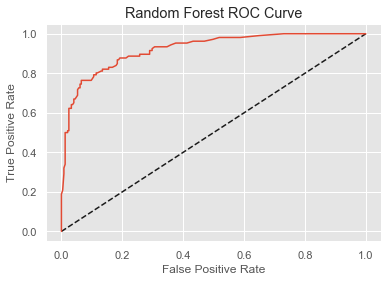

In [85]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = rfc.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='RFC')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Random Forest ROC Curve')

In [86]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9224104736234117


In [87]:
r = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       245
           1       0.77      0.77      0.77       106

    accuracy                           0.86       351
   macro avg       0.83      0.84      0.83       351
weighted avg       0.86      0.86      0.86       351



- Precision and recall scores were pretty good, with F1-scores of 0.77 for AD and 0.90 for non AD.

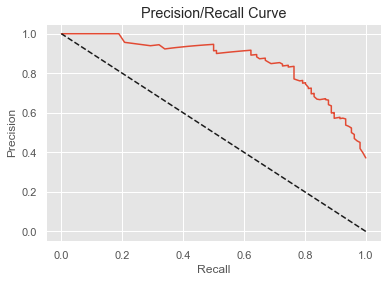

In [88]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve for the Random Forests model shows that this model performs better than SVM at high precision. So far, this model is close to competing with SVM for the best choice, depending on the circumstance.

#### AdaBoost

In [89]:
# tune hyperparameter number of estimators
est = [41, 51, 61, 71, 81]

param_grid = {'n_estimators': est}

boost = AdaBoostClassifier(random_state=42)

boost_cv = GridSearchCV(boost, param_grid, cv=5)

boost_cv.fit(Xb_train, yb_train)

n_est = boost_cv.best_params_['n_estimators']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 51} 0.8608058608058609


In [90]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xb_train, yb_train)
y_pred = model.predict(Xb_test)
print('Training accuracy: {}'.format(model.score(Xb_train, yb_train)))
print('Testing accuracy: {}'.format(model.score(Xb_test, yb_test)))

Training accuracy: 0.9084249084249084
Testing accuracy: 0.8660968660968661


In [91]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[220  25]
 [ 22  84]]
True Negatives: 220
False Positives: 25
False Negatives: 22
True Positives: 84


- This model slightly improved on the Random Forest model, with a detection rate of 79% and a false positive rate of 10%. 
- This could be a very good choice for a model for someone that wanted a middle of the road approach to predicting AD. The detection rate is pretty high at nearly 4/5, and the false positive rate is acceptably low at just 1/10 for patients that wouldn't develop AD (in the time frame of this study).
- While not the best model for detecting AD or the best for reducing false positives, this model may be the best compromise between those options.

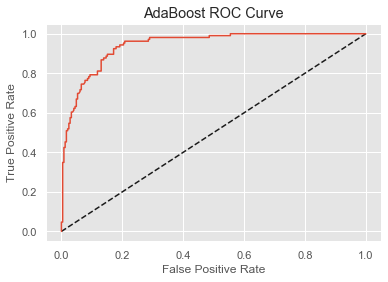

In [92]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Boost')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('AdaBoost ROC Curve')

In [93]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9415286869464767


In [94]:
b = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       245
           1       0.77      0.79      0.78       106

    accuracy                           0.87       351
   macro avg       0.84      0.85      0.84       351
weighted avg       0.87      0.87      0.87       351



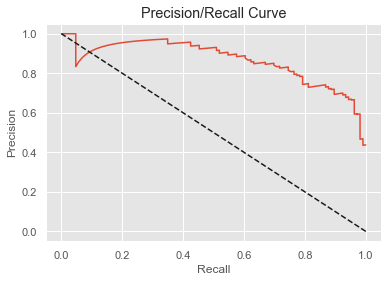

In [95]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision, recall, and F1-scores were pretty good for this model. The precision/recall curve is displaying the usual tradeoff in recall at high precision levels, but overall this was a good model that would be useful for predicting Alzheimer's disease.

- Simple feature selection using feature_importances_

In [96]:
# get the feature importances in a dataframe
feat = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
feat.sort_values('importance', ascending=False)

,feature,importance
9,MidTemp_bl,0.235294
2,ADAS13_bl,0.196078
0,CDRSB_bl,0.117647
6,Ventricles_bl,0.098039
8,Entorhinal_bl,0.098039
7,WholeBrain_bl,0.078431
3,MMSE_bl,0.058824
4,RAVLT_immediate_bl,0.058824
5,Hippocampus_bl,0.058824
1,ADAS11_bl,0.000000


In [97]:
# omit zero importance features and run the model again
mask = (feature_names != 'ADAS11_bl') & (feature_names != 'PTGENDER_Male')
Xtrain_reduced = Xb_train[:,mask]
Xtest_reduced = Xb_test[:,mask]

est = [1, 11, 21, 31, 41]
param_grid = {'n_estimators': est}
boost = AdaBoostClassifier(random_state=42)
boost_cv = GridSearchCV(boost, param_grid, cv=5)
boost_cv.fit(Xtrain_reduced, yb_train)
n_est = boost_cv.best_params_['n_estimators']
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 11} 0.8571428571428571


In [98]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xtrain_reduced, yb_train)
y_pred = model.predict(Xtest_reduced)
print('Training accuracy: {}'.format(model.score(Xtrain_reduced, yb_train)))
print('Testing accuracy: {}'.format(model.score(Xtest_reduced, yb_test)))

Training accuracy: 0.8852258852258852
Testing accuracy: 0.8490028490028491


In [99]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[220  25]
 [ 28  78]]
True Negatives: 220
False Positives: 25
False Negatives: 28
True Positives: 78


- Somehow this actually decreased the model's predictive power. The number of false positives remained the same, however, the detection power decreased. The first full feature model is better.

#### Logistic Regression

In [100]:
# build the model
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg.fit(Xb_train, yb_train)

# generate predictions
y_pred = logreg.predict(Xb_test)

In [101]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg.score(Xb_train, yb_train)))
print('The test accuracy was: {}'.format(logreg.score(Xb_test, yb_test)))

The training accuracy was: 0.8669108669108669
The test accuracy was: 0.8660968660968661


In [102]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[208  37]
 [ 10  96]]
True Negatives: 208
False Positives: 37
False Negatives: 10
True Positives: 96


- As with the change in biomarkers, logistic regression has shown to have the highest prediction power so far, tied with SVM (about 91%). This model did improve on SVM's false positive rate, with just 15% of patients flagged as positive that didn't receive an AD diagnosis.
- This model has fantastic performance. If it were me, I would be fine with a 15% false positive rate for a 91% detection rate for AD.
- I would be fine alerting 15% of people who wouldn't be diagnosed with AD that they are at higher risk of the disease and should start brain training exercises and begin early treatment to achieve the 91% detection rate.

In [103]:
l = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       245
           1       0.72      0.91      0.80       106

    accuracy                           0.87       351
   macro avg       0.84      0.88      0.85       351
weighted avg       0.88      0.87      0.87       351



- Precision suffers a little at the expense of recall for this model, however, the F1-scores for both the non-AD class and AD class are pretty high (0.90 and 0.80).

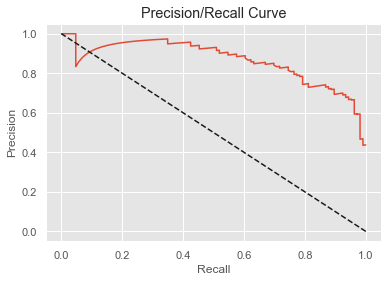

In [104]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

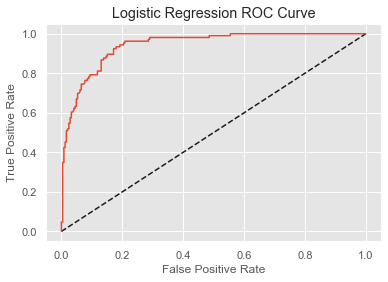

In [105]:
# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Logistic Regression')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Logistic Regression ROC Curve')

In [106]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9415286869464767


- Again, the tradeoff of recall at high precision is evident, but the precision does not drop as quickly as recall increases as some of the other models.
- The AUC is a very good score, slightly skewed by the negative class, but it shows that this model works very well.

- Simple feature selection using the coefficients from the logistic model

In [107]:
# print the coefficients for understanding feature importance
feat = pd.DataFrame({'feature': feature_names, 'coefficients': logreg.coef_[0]})
feat.loc[:,'abs_c'] = abs(feat.coefficients)
feat.sort_values('abs_c', ascending=False)

,feature,coefficients,abs_c
0,CDRSB_bl,1.313807,1.313807
2,ADAS13_bl,0.779989,0.779989
4,RAVLT_immediate_bl,-0.697177,0.697177
9,MidTemp_bl,-0.595124,0.595124
7,WholeBrain_bl,0.520630,0.520630
8,Entorhinal_bl,-0.470254,0.470254
3,MMSE_bl,-0.389243,0.389243
5,Hippocampus_bl,-0.362556,0.362556
6,Ventricles_bl,-0.157860,0.157860
10,PTGENDER_Male,0.053178,0.053178


In [108]:
# running the model without PTGENDER and ADAS11_bl: indexes 10 and 1
mask = (feat.feature != 'PTGENDER_Male') & (feat.feature != 'ADAS11_bl')
Xtrain_reduced = Xb_train[:,mask]
Xtest_reduced = Xb_test[:,mask]

In [109]:
# build the model
logreg2 = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg2.fit(Xtrain_reduced, yb_train)

# generate predictions
y_pred = logreg2.predict(Xtest_reduced)

In [110]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg2.score(Xtrain_reduced, yb_train)))
print('The test accuracy was: {}'.format(logreg2.score(Xtest_reduced, yb_test)))

The training accuracy was: 0.8656898656898657
The test accuracy was: 0.8746438746438746


In [111]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[211  34]
 [ 10  96]]
True Negatives: 211
False Positives: 34
False Negatives: 10
True Positives: 96


- Model performance was very similar, with three fewer false positives and the same detection rate. As the primary goal is to detect Alzheimer's disease, this is not necessarily an improvement over the original model.

#### Naive Bayes

In [112]:
# get rid of negative values in the feature data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(Xb_train)

# instantize the model
model = MultinomialNB()

# fit the model
model.fit(X_scaled, yb_train)

# generate predictions
y_pred = model.predict(Xb_test)

In [113]:
# print the accuracy
print('The training accuracy was: {}'.format(model.score(X_scaled, yb_train)))
print('The test accuracy was: {}'.format(model.score(Xb_test, yb_test)))

The training accuracy was: 0.796092796092796
The test accuracy was: 0.8632478632478633


In [114]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[208  37]
 [ 11  95]]
True Negatives: 208
False Positives: 37
False Negatives: 11
True Positives: 95


- The Naive Bayes model functioned pretty well, with a detection rate of nearly 90% and a false positive rate of just 15%. This was on par with the SVM and Logistic Regression models.
- Again, these are very acceptable rates for implementing a model to predict Alzheimer's Disease.

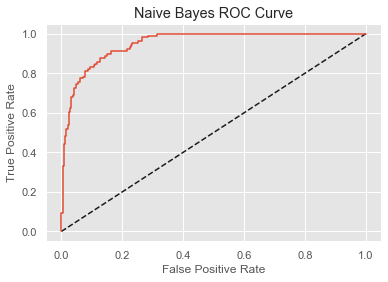

In [115]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='NB')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Naive Bayes ROC Curve')

In [116]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9506738544474393


In [117]:
n = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       245
           1       0.72      0.90      0.80       106

    accuracy                           0.86       351
   macro avg       0.83      0.87      0.85       351
weighted avg       0.88      0.86      0.87       351



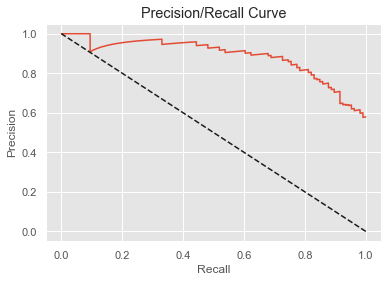

In [118]:
# plot the precision/recall curve
y_pred_prob = model.predict_proba(Xb_test)[:,1]
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision/recall curve for Naive Bayes looks a little better than some of the other curves, and this is evident with F1-scores tied with logistic regression for the best 80/90 for AD/non-AD classes.

## 2. Predicting AD with Baseline Biomarkers Summary

- The Logistic Regression and Naive Bayes models performed the best. They achived high detection rates of 90% or more with false positive rates down in the 15% range. 
- The performance of these models was much better than expected, and they outperformed the change in biomarker models. 
    - One possible reason for this is that patients that began the study with Alzheimer's Disease were included in the 'No Change' or negative group for that set of models. The goal was to detect a change in diagnosis, and those patients did not experience a change in diagnosis. One option would be to exclude those that began the study with AD from the analysis. That would reduce the negative class and would not affect the AD class.

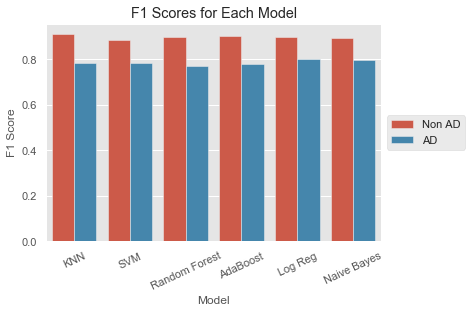

In [119]:
# plot the f1-scores for each model
ml.plot_f1_scores(k, s, r, b, l, n)

- While is should be noted that the data were imbalanced, with more observations from the non-AD (negative) class, this is also representative of the population, where most people don't develop Alzheimer's disease.

## 3. Improving the Models
- The goal of this section is to improve the models. There will be three different approaches to this.
    - Limiting the data to just the clinical biomarkers. Brain scans are expensive for patients, medical care providers, and insurance companies. A model that is capable of predicting Alzheimer's Disease without using brain scan data would be very useful.
    - Using dimension reduction to decrease model complexity and remove some of the background noise that might be hindering model performance.
        - PCA and feature selection
    - Using ensemble techniques in conjunction with dimension reduction, combining multiple models to improve predictions.

#### Clinical Biomarkers Only
- Techniques for model tuning and training have already been displayed, so a single function will be used to evaluate models.
    - The output of this function will be a dataframe that contains summary information for the models.
    - The precision and recall values reported are for the positive (AD) class. F1-scores for both classes are reported.

#### Change in Clinical Biomarkers

In [120]:
df = ml.run_clinical_models(final_exam, biomarkers='deltas')

In [121]:
df

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.882724,0.891496,0.908278,30,24,274,13,0.697674,0.555556,0.936752,0.618557
1,svm,0.854981,0.818182,0.908569,44,10,235,52,0.458333,0.814815,0.883459,0.586667
2,RF,1.000000,0.870968,0.912860,26,28,271,16,0.619048,0.481481,0.924915,0.541667
3,AdaBoost,0.912989,0.873900,0.873403,34,20,264,23,0.596491,0.629630,0.924694,0.612613
4,logreg,0.860025,0.859238,0.921022,45,9,248,39,0.535714,0.833333,0.911765,0.652174
5,bayes,0.839849,0.873900,0.886889,26,28,272,15,0.634146,0.481481,0.926746,0.547368


- The logistic regression model had a very good performance even without using any of the scan data. It had an 83% detection rate for AD, and the false positive rate was only 14%. These are good numbers to use this model to warn patients that they are experiencing a decline towards AD.
- The SVM model performed almost as well as the logistic model with an 81% detection rate and an 18% false positive rate.
- The k-NN model performed well for the negative class, as did random forests, but as the goal is predicting the positive class (Alzheimer's Disease), the logistic model and SVM model are the best.

#### Baseline Clinical Biomarkers

In [122]:
df2 = ml.run_clinical_models(final_exam, biomarkers='baseline')

In [123]:
df2

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.849937,0.850440,0.866918,7,47,283,4,0.636364,0.129630,0.917342,0.215385
1,svm,0.778058,0.768328,0.837786,46,8,216,71,0.393162,0.851852,0.845401,0.538012
2,RF,1.000000,0.809384,0.825300,10,44,266,21,0.322581,0.185185,0.891122,0.235294
3,AdaBoost,0.860025,0.829912,0.809008,18,36,265,22,0.450000,0.333333,0.901361,0.382979
4,logreg,0.680958,0.668622,0.731385,38,16,190,97,0.281481,0.703704,0.770791,0.402116
5,bayes,0.839849,0.759531,0.752613,3,51,256,31,0.088235,0.055556,0.861953,0.068182


- Not surprisingly, the models for the baseline data generally didn't do as well without the brain scan data.
- A major exception to this is the SVM model. The SVM model had an 85% detection rate for AD with a false positive rate of just 25%.
    - Considering this model is just using clinical biomarkers and no brain scan data, this is a phenomenal result.
    - This model can be used to help determine which patients should go for brain scans, and help to screen out patients that should not.
- The logistic model did ok with a 70% detection rate and a 34% false positive rate. I would consider these numbers too high to make for a practical predictive model, especially when the SVM model performed so well.

#### Principal Components Analysis for Dimension Reduction

- Change in Biomarkers

In [124]:
# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

In [125]:
# separate into training and test data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, stratify=yd)

In [126]:
# create PCA instance
pca = PCA()

# fit on sample data
pca.fit(Xd_train)

# can use to transform sample data or test/unseen data
Xpca_train_all = pca.transform(Xd_train)
Xpca_test_all = pca.transform(Xd_test)

# examine percent of variance explained by each principal component
print(pca.explained_variance_/np.sum(pca.explained_variance_))

[0.46319687 0.12359159 0.0916614  0.07647554 0.06330223 0.04950511
 0.04100379 0.03238088 0.03009303 0.02562239 0.00316715]


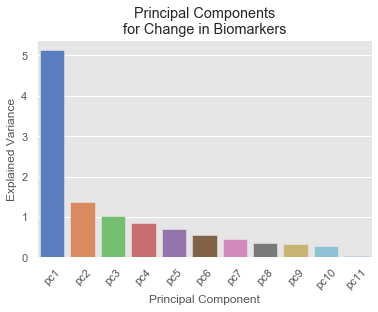

In [127]:
labels = ['pc' + str(i+1) for i in range(feature_names.shape[0])]
ax = sns.barplot(labels, pca.explained_variance_, palette='muted')
_ = plt.setp(ax.get_xticklabels(), rotation=45)
_ = plt.title('Principal Components\nfor Change in Biomarkers')
_ = plt.xlabel('Principal Component')
_ = plt.ylabel('Explained Variance')

- The principal component analysis for the change in biomarker data shows that 10 principal components are required to explain most of the variance in the data. About 95% of the variance can be explained using 8 principal components, so the models will be run using that number of components.

In [128]:
# slice the first 8 principal components
Xpca_train = Xpca_train_all[:,0:8]
Xpca_test = Xpca_test_all[:,0:8]

In [129]:
df3 = ml.run_models(Xpca_train, Xpca_test, yd_train, yd_test)

In [130]:
df3

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.901639,0.882698,0.875661,21,33,280,7,0.750000,0.388889,0.933333,0.512195
1,svm,0.853720,0.821114,0.903665,45,9,235,52,0.463918,0.833333,0.885122,0.596026
2,RF,1.000000,0.870968,0.894051,23,31,274,13,0.638889,0.425926,0.925676,0.511111
3,AdaBoost,0.933165,0.870968,0.850819,28,26,269,18,0.608696,0.518519,0.924399,0.560000
4,logreg,0.853720,0.847507,0.905923,43,11,246,41,0.511905,0.796296,0.904412,0.623188
5,bayes,0.839849,0.870968,0.891663,29,25,268,19,0.604167,0.537037,0.924138,0.568627


- PCA appeared to stabilize the logistic model over the full feature model, losing some predicitive power with an 81% detection rate, but improving the false positive rate to 13%. The SVM model performed ok after PCA, but it still had a relatively high false positive rate.
- Since 10 of the 11 principal components appeared to contribute to the variation in the data, the models will be run using 10 PC's for comparison.

In [131]:
# slice the first 10 principal components
Xpca_train = Xpca_train_all[:,0:10]
Xpca_test = Xpca_test_all[:,0:10]

In [132]:
df4 = ml.run_models(Xpca_train, Xpca_test, yd_train, yd_test)
df4

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.901639,0.888563,0.863466,24,30,279,8,0.750000,0.444444,0.936242,0.558140
1,svm,0.872636,0.835777,0.917151,46,8,239,48,0.489362,0.851852,0.895131,0.621622
2,RF,1.000000,0.862170,0.883469,19,35,275,12,0.612903,0.351852,0.921273,0.447059
3,AdaBoost,0.928121,0.879765,0.889276,27,27,273,14,0.658537,0.500000,0.930153,0.568421
4,logreg,0.862547,0.838710,0.912892,44,10,242,45,0.494382,0.814815,0.897959,0.615385
5,bayes,0.839849,0.873900,0.892051,29,25,269,18,0.617021,0.537037,0.925990,0.574257


- The 10 PC data performed better (not surprisingly), with the logistic model and SVM models notably improved over the 8 PC version.
- While this is an improvement, this does not reduce the dimensionality of the data very much, and could still be prone to overfitting on further unseen data.
- The next approach to reducing the dimension in the change in biomarkers data will be to do feature selection analysis. There are multiple approaches that would work for this, including using ANOVA tests to compare within group sum of squares to the total sum of squares for all features. This analysis will use classes created and publicly available on GitHub at [https://github.com/WillKoehrsen/feature-selector](https://github.com/WillKoehrsen/feature-selector)

#### PCA for the Baseline Biomarkers

In [133]:
# extract and scale the deltas data for ML analysis
feature_names, X, y = ml.get_bl_data(final_exam)

In [134]:
# separate into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [135]:
# create PCA instance
pca = PCA()

# fit on sample data
pca.fit(X_train)

# can use to transform sample data or test/unseen data
Xpca_train_all = pca.transform(X_train)
Xpca_test_all = pca.transform(X_test)

# examine percent of variance explained by each principal component
print(pca.explained_variance_/np.sum(pca.explained_variance_))

[0.48094556 0.1963947  0.08673164 0.05416536 0.0457337  0.03798491
 0.02923681 0.02513995 0.02368939 0.01790394 0.00207405]


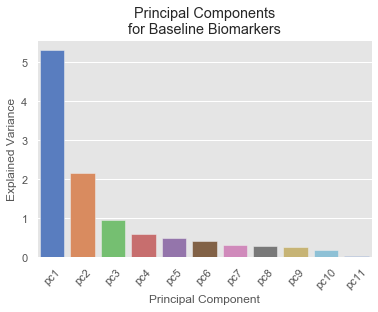

In [136]:
labels = ['pc' + str(i+1) for i in range(feature_names.shape[0])]
ax = sns.barplot(labels, pca.explained_variance_, palette='muted')
_ = plt.setp(ax.get_xticklabels(), rotation=45)
_ = plt.title('Principal Components\nfor Baseline Biomarkers')
_ = plt.xlabel('Principal Component')
_ = plt.ylabel('Explained Variance')

- Over 95% of the variance is explained from the first 8 biomarkers, so those will be used for the pca for the baseline biomarkers.

In [137]:
# slice the first 8 principal components
Xpca_train = Xpca_train_all[:,0:8]
Xpca_test = Xpca_test_all[:,0:8]

In [138]:
df5 = ml.run_models(Xpca_train, Xpca_test, y_train, y_test)
df5

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.876679,0.851852,0.929746,70,36,229,16,0.813953,0.660377,0.898039,0.729167
1,svm,0.881563,0.851852,0.931382,93,13,206,39,0.704545,0.877358,0.887931,0.781513
2,RF,1.000000,0.854701,0.912591,76,30,224,21,0.783505,0.716981,0.897796,0.748768
3,AdaBoost,0.916972,0.820513,0.913689,79,27,209,36,0.686957,0.745283,0.869023,0.714932
4,logreg,0.879121,0.860399,0.938352,90,16,212,33,0.731707,0.849057,0.896406,0.786026
5,bayes,0.698413,0.866097,0.930882,72,34,232,13,0.847059,0.679245,0.908023,0.753927


- The 8 principal component data performed relatively well. The SVM model had an 89% detection rate and the logistic model had an 86% detection rate. Those models had just 15% and 13% false positive rates respectively.
- It is important to note that this did not improve model performance overall that used the full dataset, failing to achieve detection rates as high or false positive rates as low as the models without using PCA.
- A 10 PC test will be examined to see if these numbers can be improved.

In [139]:
# slice the first 10 principal components
Xpca_train = Xpca_train_all[:,0:10]
Xpca_test = Xpca_test_all[:,0:10]

In [140]:
df6 = ml.run_models(Xpca_train, Xpca_test, y_train, y_test)
df6

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.877900,0.857550,0.938198,70,36,231,14,0.833333,0.660377,0.902344,0.736842
1,svm,0.875458,0.846154,0.933654,93,13,204,41,0.694030,0.877358,0.883117,0.775000
2,RF,1.000000,0.840456,0.910820,73,33,222,23,0.760417,0.688679,0.888000,0.722772
3,AdaBoost,0.943834,0.837607,0.910243,77,29,217,28,0.733333,0.726415,0.883910,0.729858
4,logreg,0.880342,0.849003,0.939738,92,14,206,39,0.702290,0.867925,0.886022,0.776371
5,bayes,0.698413,0.860399,0.930497,71,35,231,14,0.835294,0.669811,0.904110,0.743455


- Using the first 10 principal components did not improve either of the best models. The k-NN model did worse, but the random forest, boosting, and Bayes models were slightly improved.
- Overall, I think there was no real gain in using 10 principal components, and these gains may be superficial if the models were applied to further unseen data.
- The next step to improve the models is to use feature selection. The same tool being used for the change in biomarker data will also be applied to the baseline biomarkers.

#### Feature Selection

- FeatureSelector Class

In [141]:
# import the feature selection class
from feature_selector import FeatureSelector

- This tool will be used to search for three circumstances to consider excluding features:
    - Collinearity
        - If found, linear regression will be used to quantify the relationship and determine whether or not to exclude certain features.
    - Zero Importance Features
        - This tool uses Gradient Boosting to search for zero importance features, that do not contribute to predicting the target.
    - Low Importance Features
        - The Gradient Boosting method will assign normalized importance values based on the amount of variance in the target that is explained by each feature.

- Change in Biomarkers Data

In [142]:
# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

In [143]:
# separate into training and test data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, stratify=yd)

In [144]:
# convert to dataframe for the feature selector
X_train = pd.DataFrame(Xd_train, columns=feature_names)
y_train = pd.DataFrame(yd_train, columns=['y'])

In [145]:
# create an instance
fs = FeatureSelector(data=X_train, labels=y_train)

In [146]:
# identify collinear features
fs.identify_collinear(correlation_threshold=0.75)

1 features with a correlation magnitude greater than 0.75.



In [147]:
# extract the collinear features
correlated_features = fs.ops['collinear']

In [148]:
# print the correlated features
print(correlated_features)

['ADAS13_delta']


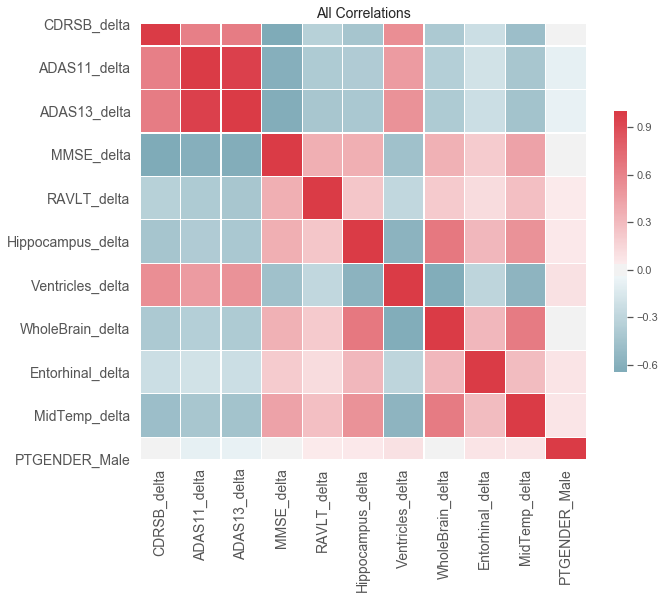

In [149]:
# visualize the heatmap of the correlations
fs.plot_collinear(plot_all=True)

In [150]:
# calculate the r-squared and relationship
clf = linear_model.LinearRegression()
clf.fit(np.array(X_train.ADAS11_delta).reshape(-1,1), np.array(X_train.ADAS13_delta).reshape(-1,1))
r_squared = clf.score(np.array(X_train.ADAS11_delta).reshape(-1,1), np.array(X_train.ADAS13_delta).reshape(-1,1))
r_squared

0.9227047138423462

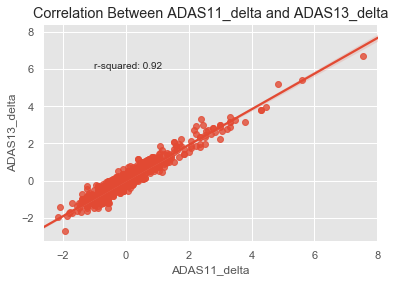

In [151]:
# examine the relationship
_ = sns.regplot(x='ADAS11_delta', y='ADAS13_delta', data=X_train)
_ = plt.title('Correlation Between ADAS11_delta and ADAS13_delta')
_ = plt.text(-1, 6, 'r-squared: {}'.format(round(r_squared, 2)))

In [152]:
# identify zero-importance features
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.936579	valid_0's binary_logloss: 0.419598
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.900789	valid_0's binary_logloss: 0.309567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.871579	valid_0's binary_logloss: 0.278193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.917368	valid_0's binary_logloss: 0.300818
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.868421	valid_0's binary_logloss: 0.311065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's auc: 0.944737	valid_0's binary_logloss: 0.215365
T

- no features were found with zero importance.

In [153]:
# identify features with low importance
fs.identify_low_importance(cumulative_importance = 0.99)

9 features required for cumulative importance of 0.99 after one hot encoding.
2 features do not contribute to cumulative importance of 0.99.



In [154]:
# examine the low importance feature
low_importance_features = fs.ops['low_importance']
low_importance_features

['RAVLT_delta', 'PTGENDER_Male']

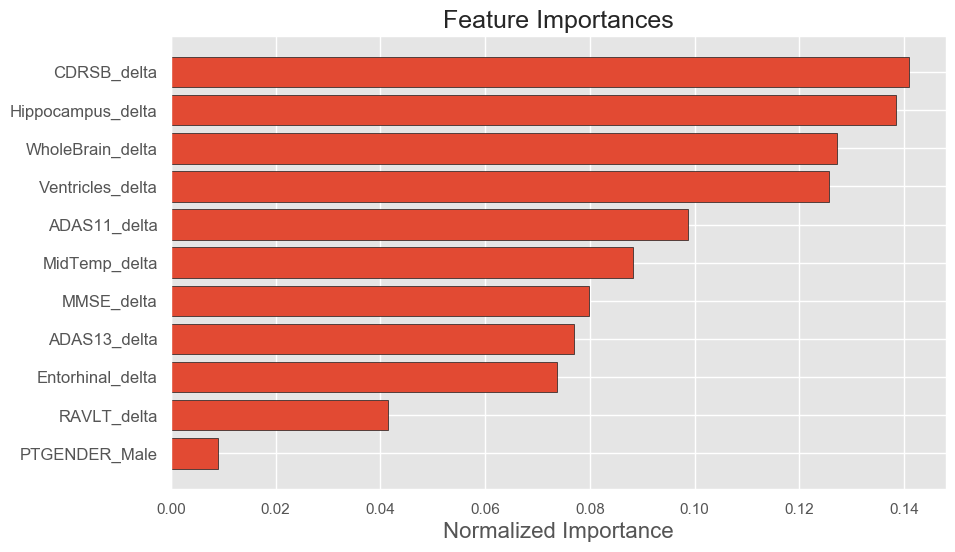

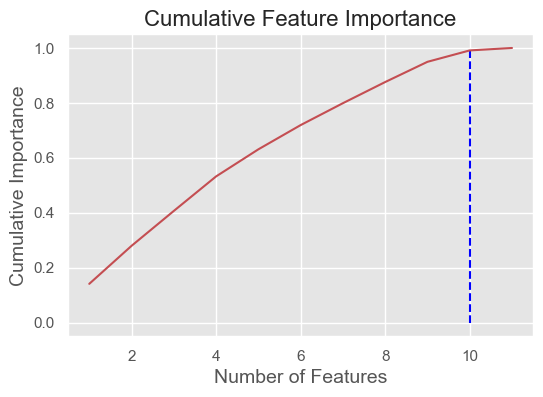

10 features required for 0.99 of cumulative importance


In [155]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 11)

#### Results of Feature Selection for Change in Biomarkers
- ADAS13_delta is collinear with ADAS11_delta
    - ADAS13_delta will be removed from the model
- PTGENDER has a very low importance with the model
    - This is surprising as statistical analysis suggested gender had an impact on certain biomarkers.
    - It would appear, though, that PTGENDER does not influence whether or not a patient was more/less likely to be diagnosed with Alzheimer's Disease during this study.

#### Running the models with a reduced number of features

In [156]:
# drop the features identified from feature selection
X_train.drop(columns=['ADAS13_delta', 'PTGENDER_Male'], inplace=True)
X_test = pd.DataFrame(Xd_test, columns=feature_names)
X_test.drop(columns=['ADAS13_delta', 'PTGENDER_Male'], inplace=True)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [157]:
ml.run_models(X_train, X_test, yd_train, yd_test)

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.895334,0.885630,0.926119,19,35,283,4,0.826087,0.351852,0.935537,0.493506
1,svm,0.882724,0.850440,0.915376,45,9,245,42,0.517241,0.833333,0.905730,0.638298
2,RF,1.000000,0.894428,0.931765,23,31,282,5,0.821429,0.425926,0.940000,0.560976
3,AdaBoost,0.901639,0.870968,0.926958,29,25,268,19,0.604167,0.537037,0.924138,0.568627
4,logreg,0.851198,0.847507,0.944767,45,9,244,43,0.511364,0.833333,0.903704,0.633803
5,bayes,0.839849,0.900293,0.919022,33,21,274,13,0.717391,0.611111,0.941581,0.660000


- The new models that use fewer features had pretty good performance. The models that performed the best changed slightly, but the SVM model had the highest detection rate at 87%, with a false positive rate of 15%. The logistic model performed worse on the positive class, but gained performance in the negative class (76% detection rate and just a 9% false positive rate).

#### Baseline Biomarkers Feature Selection

In [158]:
# extract and scale the deltas data for ML analysis
feature_names, X, y = ml.get_bl_data(final_exam)

In [159]:
# separate into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [160]:
# convert to dataframe for the feature selector
Xf_train = pd.DataFrame(X_train, columns=feature_names)
yf_train = pd.DataFrame(y_train, columns=['y'])

In [161]:
# create an instance
fs = FeatureSelector(data=Xf_train, labels=yf_train)

In [162]:
# identify collinear features
fs.identify_collinear(correlation_threshold=0.9)

1 features with a correlation magnitude greater than 0.90.



In [163]:
# extract the collinear features
correlated_features = fs.ops['collinear']

In [164]:
# print the correlated features
print(correlated_features)

['ADAS13_bl']


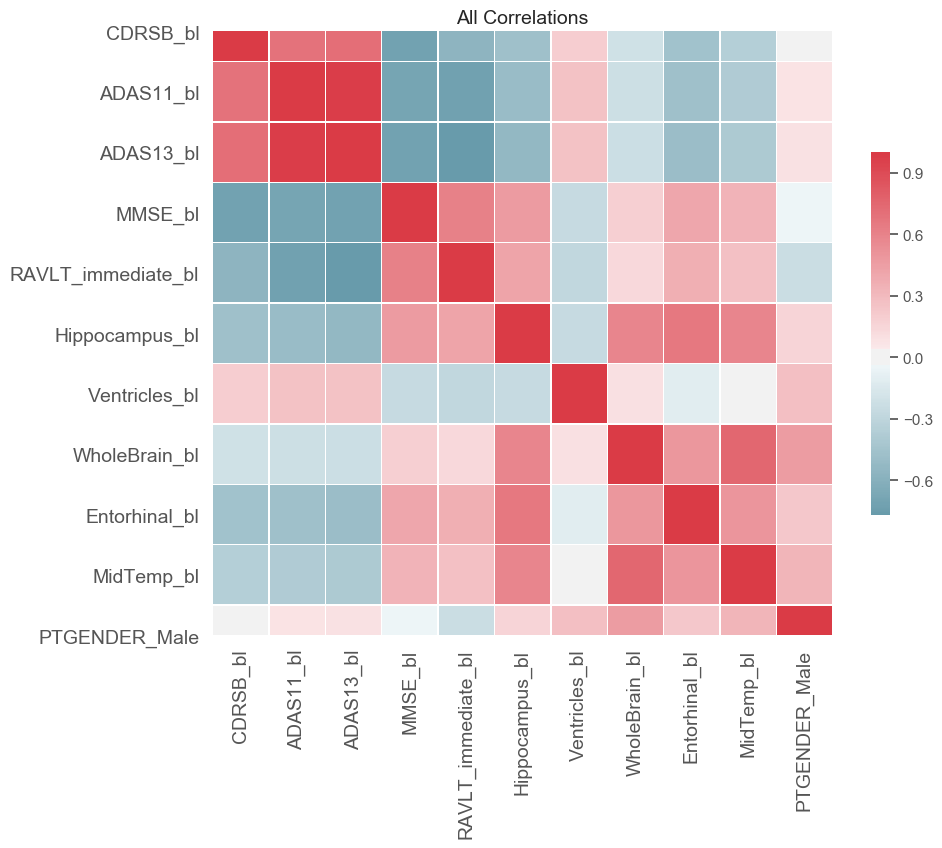

In [165]:
# visualize the heatmap of the correlations
fs.plot_collinear(plot_all=True)

In [166]:
# calculate the r-squared and relationship
clf = linear_model.LinearRegression()
clf.fit(np.array(Xf_train.ADAS11_bl).reshape(-1,1), np.array(Xf_train.ADAS13_bl).reshape(-1,1))
r_squared = clf.score(np.array(Xf_train.ADAS11_bl).reshape(-1,1), np.array(Xf_train.ADAS13_bl).reshape(-1,1))
r_squared

0.9493127918072687

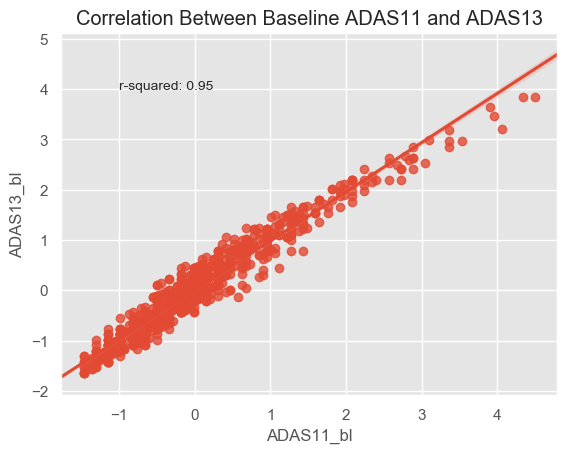

In [167]:
# examine the relationship
_ = sns.regplot(x='ADAS11_bl', y='ADAS13_bl', data=Xf_train)
_ = plt.title('Correlation Between Baseline ADAS11 and ADAS13')
_ = plt.text(-1, 4, 'r-squared: {}'.format(round(r_squared, 2)))

In [168]:
# identify zero-importance features
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.961659	valid_0's binary_logloss: 0.306016
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.954431	valid_0's binary_logloss: 0.29137
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.897234	valid_0's binary_logloss: 0.352971
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.936204	valid_0's binary_logloss: 0.297224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.928661	valid_0's binary_logloss: 0.345668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.95616	valid_0's binary_logloss: 0.489938
Tra

- no features were found with zero importance.

In [169]:
# identify features with low importance
fs.identify_low_importance(cumulative_importance = 0.99)

9 features required for cumulative importance of 0.99 after one hot encoding.
2 features do not contribute to cumulative importance of 0.99.



In [170]:
# examine the low importance feature
low_importance_features = fs.ops['low_importance']
low_importance_features

['MMSE_bl', 'PTGENDER_Male']

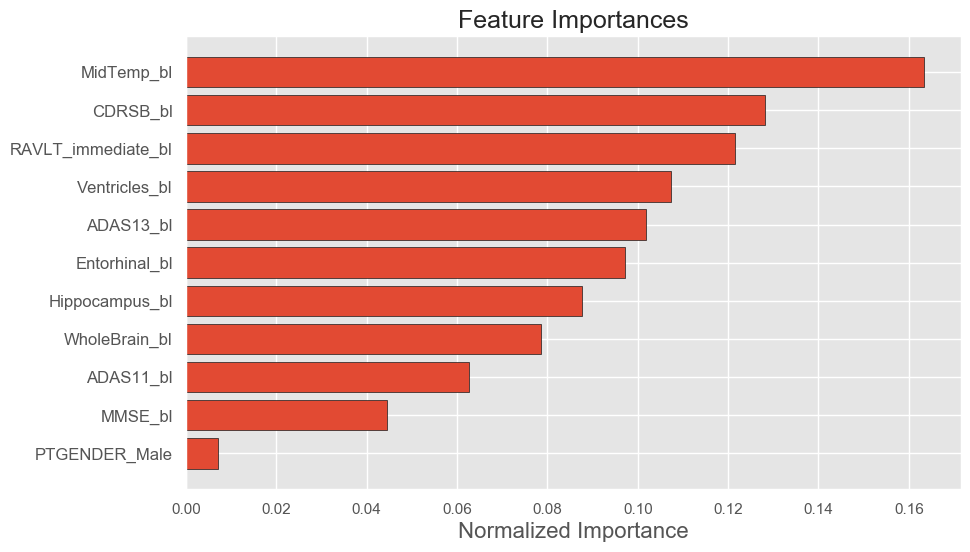

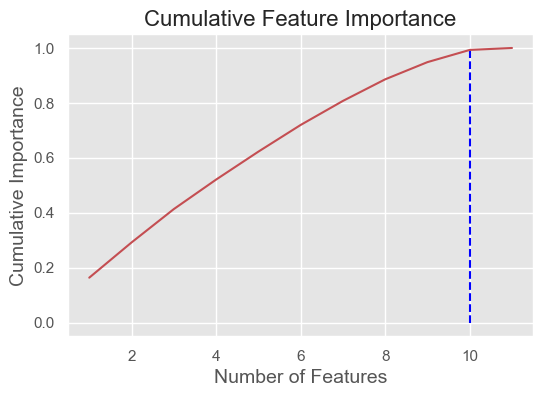

10 features required for 0.99 of cumulative importance


In [171]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 11)

- The feature selection class identified PTGENDER and MMSE_bl as having low importance, however, the MMSE_bl contributes much more than PTGENDER does.
- It is again surprising that the PTGENDER is not contributing to the model, as statistical analysis indicated this was important, however, it is possible that the models are able to extract the differences in the magnitude of values between males/females through the combination of standarization of the feature values and overall relationships between the features for each individual.
- This result again suggests that PTGENDER by itself was not a major contributing factor in whether or not a patient was diagnosed with AD during this study.

#### Running the models with a reduced number of features

In [172]:
# drop the features identified from feature selection
Xf_train.drop(columns=['ADAS13_bl', 'PTGENDER_Male'], inplace=True)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test.drop(columns=['ADAS13_bl', 'PTGENDER_Male'], inplace=True)
X_train = np.array(Xf_train)
X_test = np.array(X_test)

In [173]:
# run the models with the reduced number of features
ml.run_models(X_train, X_test, y_train, y_test)

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.877900,0.868946,0.923431,84,22,221,24,0.777778,0.792453,0.905738,0.785047
1,svm,0.898657,0.823362,0.909357,93,13,196,49,0.654930,0.877358,0.863436,0.750000
2,RF,1.000000,0.866097,0.929650,84,22,220,25,0.770642,0.792453,0.903491,0.781395
3,AdaBoost,0.899878,0.871795,0.929611,87,19,219,26,0.769912,0.820755,0.906832,0.794521
4,logreg,0.876679,0.834758,0.942626,93,13,200,45,0.673913,0.877358,0.873362,0.762295
5,bayes,0.769231,0.860399,0.934039,92,14,210,35,0.724409,0.867925,0.895522,0.789700


- The models did not quite achieve the detection rates that were found when using all of the features (two achieved 90% detection). The Naive Bayes did score about 89% detection rate, while SVM and logistic regression scored about 88%.
- The Naive Bayes model did improve on the false positive rate slightly with a 14% rate, while the SVM and logistic models had false positive rates of about 16%. 
- These numbers were very similar to those that used all features, giving slightly on the positive class and improving slightly on the negative class.
- Overall, it is likely that a small amount of noise was removed from the models, and I would expect the reduced dimension models to perform better on unseen data.

#### Dimension Reduction Summary
- PCA was able to improve of the models a little at the expense of loss of interpretability in the features.
    - This is an acceptable tradeoff, as the ultimate goal is predicting Alzheimer's disease, not in determining which features contributed the most.
- Feature selection was able to identify a couple of features that should be removed from the machine learning analysis, because they do not contribute significantly to the model performance.
    - For both the change in biomarkers and the baseline biomarkers, ADAS13 was removed due to high collinearity with ADAS11. PTGENDER was removed because although it appears to contribute to the magnitude of values for the features, it did not factor in determining whether or not a patient would be diagnosed with Alzheimer's disease in this study.
- Some of the models were run with reduced dimensions after analyzing the model coefficients and importance. In general these made little or no improvements on the models.

## Grand Ensemble Models

- The goal of this section is to create an ensemble model comprised of the best performing models to get the highest detection rate possible. A bonus would be to decrease the false positive rate, but the primary goal is identifying patients that are higher risk for Alzheimer's, so this section will focus on optimizing detection rate (recall).

- Methods
    - The VotingClassifier class from sklearn did not work, as one of the models has a different number of features and uses PCA
        - There may be a way to use this with a pipeline, but this model will be calculated manually to ensure accurate results
    - The best performing 3 or 5 models will be used (so a majority can be reached)
        - The models must either use a different set of the training data or use a different algorithm from the other individual models to be included in the ensemble model

### Change in Biomarkers Ensemble Model
- Best performing models:
    - SVM with ADAS13_delta and PTGENDER removed: 89% detection rate and 15% false positive rate
    - Logistic regression (full feature): 87% detection rate and 15% false positive rate
    - PCA logistic regression: 81% detection rate and 9% false positive rate

In [174]:
# get the data
feature_names, X, y = ml.get_delta_scaled(final_exam)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# create -1, 1 labels for SVM
ysvm_train = np.where(y_train == 0, y_train - 1, y_train)
ysvm_test = np.where(y_test == 0, y_test - 1, y_test)

In [175]:
# create the models

# SVM excluding ADAS13_delta and PTGENDER_Male
# drop the features identified from feature selection
Xf_train = pd.DataFrame(X_train, columns=feature_names)
Xf_train.drop(columns=['ADAS13_delta', 'PTGENDER_Male'], inplace=True)
Xf_test = pd.DataFrame(X_test, columns=feature_names)
Xf_test.drop(columns=['ADAS13_delta', 'PTGENDER_Male'], inplace=True)
Xsv_train = np.array(Xf_train)
Xsv_test = np.array(Xf_test)
# create the SVM model
num_features = Xsv_train.shape[1]
param_grid = {'C': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*Xsv_train.var())), (1/num_features)]}
svm = SVC(class_weight='balanced', probability=True)
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(Xsv_train, ysvm_train)
C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']
svm = SVC(C=C, gamma=gamma, class_weight='balanced', probability=True)
svm.fit(Xsv_train, ysvm_train)
svm_pred_scaled = svm.predict(Xsv_test)
svm_pred = np.where(svm_pred_scaled == -1, svm_pred_scaled + 1, svm_pred_scaled)
svm_prob = svm.predict_proba(Xsv_test)[:,1]

# Logistic regression (full feature)
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_prob = logreg.predict_proba(X_test)[:,1]

# PCA logistic regression
pca = PCA()
pca.fit(X_train)
Xpca_train_all = pca.transform(X_train)
Xpca_train = Xpca_train_all[:,0:8]
Xpca_test_all = pca.transform(X_test)
Xpca_test = Xpca_test_all[:,0:8]
pca_logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)
pca_logreg.fit(Xpca_train, y_train)
pca_logreg_pred = pca_logreg.predict(Xpca_test)
pca_logreg_prob = pca_logreg.predict_proba(Xpca_test)[:,1]

In [176]:
# create a dataframe and count the votes
pred = pd.DataFrame({'svm': svm_pred, 'lr_ff': logreg_pred, 'lr_pca': pca_logreg_pred})
pred.loc[:,'total'] = pred.svm + pred.lr_ff + pred.lr_pca
mapper = {0: 0, 1: 0, 2: 1, 3: 1}
y_pred = pred.total.map(mapper)

In [177]:
# print the confusion matrix
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[242  45]
 [ 10  44]]
True Negatives: 242
False Positives: 45
False Negatives: 10
True Positives: 44


In [178]:
# print the accuracy
test_acc = (tp + tn) / (tn + fp + tp + fn)
print('Testing accuracy: {}'.format(test_acc))

Testing accuracy: 0.8387096774193549


- The ensemble model did not improve on the best model, because of disagreement between the three models used
- Weights will be assigned so that the best performing model is favored to try and improve the predictions

In [179]:
pred.loc[:,'y_pred'] = y_pred

In [180]:
# assign a positive result (prediction of 1) whenever the svm/lr_ff models predict it
svm_add = pred[(pred.y_pred == 0) & (pred.svm == 1)].index
lr_ff_add = pred[(pred.y_pred == 0) & (pred.lr_ff == 1)].index

In [181]:
pred.loc[svm_add, 'y_pred'] = 1
pred.loc[lr_ff_add, 'y_pred'] = 1

In [182]:
y_pred_weighted = pred.y_pred

In [183]:
# print the confusion matrix
print(confusion_matrix(y_test, y_pred_weighted))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_weighted).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[237  50]
 [  8  46]]
True Negatives: 237
False Positives: 50
False Negatives: 8
True Positives: 46


In [184]:
# print the accuracy
test_acc = (tp + tn) / (tn + fp + tp + fn)
print('Testing accuracy: {}'.format(test_acc))

Testing accuracy: 0.8299120234604106


- Updating the predictions so that the best models were always counted as positive improved the detection rate to 85%, still lower than the best two models independently. This is likely due to a different random state when running the models.
- This is an important result, because this probably means the original models were overfitting slightly.
- This final model has a detection rate of 85% and a false positive rate of 17%.
- This would be the recommended model for use, though more unseen data would really help to assess all of the models' performances.

### Baseline Biomarkers Ensemble Model
- Best performing models:
    - PCA SVM: 93% detection rate and 19% false positive rate
    - PCA logistic regression: 92% detection rate and 16% false positive rate
    - Logistic regression (removing PTGENDER and ADAS11_bl): 91% detection rate and 15% false positive rate
    - SVM (full feature): 91% detection rate and 18% false positive rate
    - Naive Bayes (full feature): 90% detection rate and 15% false positive rate

In [185]:
# get the data
feature_names, X, y = ml.get_bl_data(final_exam)

# split the data (use a different random state for better generalization)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, stratify=y)

# create -1, 1 labels for SVM
ysvm_train = np.where(y_train == 0, y_train - 1, y_train)
ysvm_test = np.where(y_test == 0, y_test - 1, y_test)

In [186]:
# create the models

# PCA for SVM and logreg
pca = PCA()
pca.fit(X_train)
Xpca_train_all = pca.transform(X_train)
Xpca_test_all = pca.transform(X_test)
Xpca_train = Xpca_train_all[:,0:8]
Xpca_test = Xpca_test_all[:,0:8]

# PCA SVM
num_features = Xpca_train.shape[1]
param_grid = {'C': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*Xpca_train.var())), (1/num_features)]}
svm = SVC(class_weight='balanced', probability=True)
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(Xpca_train, ysvm_train)
C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']
svm = SVC(C=C, gamma=gamma, class_weight='balanced', probability=True)
svm.fit(Xpca_train, ysvm_train)
svm_pred_scaled = svm.predict(Xpca_test)
pca_svm_pred = np.where(svm_pred_scaled == -1, svm_pred_scaled + 1, svm_pred_scaled)
pca_svm_prob = svm.predict_proba(Xpca_test)[:,1]

# PCA logistic regression
pca_logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=20)
pca_logreg.fit(Xpca_train, y_train)
pca_logreg_pred = pca_logreg.predict(Xpca_test)
pca_logreg_prob = pca_logreg.predict_proba(Xpca_test)[:,1]

# logistic regression removing PTGENDER and ADAS11_bl
Xf_train = pd.DataFrame(X_train, columns=feature_names)
Xf_train.drop(columns=['ADAS11_bl', 'PTGENDER_Male'], inplace=True)
Xf_test = pd.DataFrame(X_test, columns=feature_names)
Xf_test.drop(columns=['ADAS11_bl', 'PTGENDER_Male'], inplace=True)
Xlr_train = np.array(Xf_train)
Xlr_test = np.array(Xf_test)
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=20)
logreg.fit(Xlr_train, y_train)
logreg_red_pred = logreg.predict(Xlr_test)
logreg_red_prob = logreg.predict_proba(Xlr_test)[:,1]

# full feature SVM
num_features = X_train.shape[1]
param_grid = {'C': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*X_train.var())), (1/num_features)]}
svm = SVC(class_weight='balanced', probability=True)
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(X_train, ysvm_train)
C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']
svm = SVC(C=C, gamma=gamma, class_weight='balanced', probability=True)
svm.fit(X_train, ysvm_train)
svm_pred_scaled = svm.predict(X_test)
ff_svm_pred = np.where(svm_pred_scaled == -1, svm_pred_scaled + 1, svm_pred_scaled)
ff_svm_prob = svm.predict_proba(X_test)[:,1]

# full feature Naive Bayes
scaler = MinMaxScaler()
scaler.fit(X_train)
Xtrain_scaled = scaler.transform(X_train)
Xtest_scaled = scaler.transform(X_test)
model = MultinomialNB()
model.fit(X_scaled, y_train)
nb_pred = model.predict(Xtest_scaled)

In [187]:
# create a dataframe and count the votes
pred_bl = pd.DataFrame({'pca_svm': pca_svm_pred, 'pca_lr': pca_logreg_pred, 
                        'lr_red': logreg_red_pred, 'ff_svm': ff_svm_pred, 'ff_nb': nb_pred})
pred_bl.loc[:,'total'] = pred_bl.pca_svm + pred_bl.pca_lr + pred_bl.lr_red + pred_bl.ff_svm + pred_bl.ff_nb
mapper = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1}
y_pred_bl = pred_bl.total.map(mapper)

In [188]:
# print the confusion matrix
print(confusion_matrix(y_test, y_pred_bl))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bl).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[220  25]
 [ 12  94]]
True Negatives: 220
False Positives: 25
False Negatives: 12
True Positives: 94


In [189]:
# print the accuracy
test_acc = (tp + tn) / (tn + fp + tp + fn)
print('Testing accuracy: {}'.format(test_acc))

Testing accuracy: 0.8945868945868946


- The ensemble model produced 89% prediction rate with an 11% false positive rate.
- Though the total detection rate is a little lower than the best models, I think this model will have the best generalization ability compared to any of the individual models.
- The random state being different could have affected the results, but again, this is important for the ability to generalize.

## Machine Learning Summary
- This analysis produced several models that demonstrated the ability to predict Alzheimer's Disease:
    - Predict a progression to Alzheimer's based on changes in biomarkers
    - Predict Alzheimer's Disease using only initial measurements from a patient's first exam
    - Predict Alzheimer's Disease using only clinical biomarkers from an initial exam (not using brain scan data)
- A variety of tools were used to create classification models and modify them to improve results:
    - Classification algorithms: KNN, SVM, Random Forest, AdaBoost, Logistic Regression, and Naive Bayes
    - Dimension reduction and feature selection: coefficients from individual models, principal component analysis, and feature selection tools
    - Combining multiple models for an ensemble approach

- The individual models that performed well for predicting Alzheimer's Disease
    - Change in biomarkers:
        - Logistic regression
        - Logistic regression on principal components
        - SVM with ADAS13_delta and PTGENDER removed
    - Baseline biomarkers:
        - SVM on principal components
        - Logistic regression on principal components
        - Logistic regression with ADAS11_bl and PTGENDER removed
        - SVM
        - Naive Bayes
- Individual models that performed well on clinical biomarkers only
    - Change in biomarkers:
        - Logistic regression
        - SMV
    - Baseline biomarkers:
        - SVM
        - Logistic regression
- Ensemble models showed sufficient detection rates with acceptable false positive rates

#### Important Uses for Models
- Flagging patients as being higher risk of Alzheimer's disease and needing to get brain scans using only data from clinical exams collected at a patient's first visit
- Using combined clinical data and brain scan data to predict which patients are higher risk of developing Alzheimer's disease after only one visit
- Using data collected over multiple visits to determine which patients are experience a progression in biomarkers that suggests they are at risk of developing Alzheimer's Disease

#### Potential Gains from Using These Models
- Early detection of at risk patients
    - signify which patients should go for brain scans
    - begin early treatment
    - prepare financially and emotionally for the disease
- Monetary gains
    - help determine which patients should/should not schedule expensive brain scans
        - helps patients, hospitals, and insurance companies save money
    - some early treatment options are inexpensive and have long term effects that can reduce the total cost to the patient